-----
# Prepare a Graph with different node colors per layout
-----

In [1]:
import networkx as nx
from sklearn import preprocessing 
import pandas as pd
import json
import random
import seaborn as sns
import csv 
from cartoGRAPHs import *

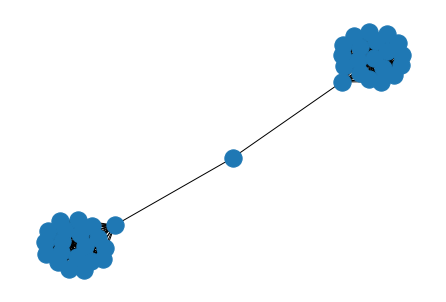

In [2]:
n=20
m=1

G = nx.barbell_graph(n, m)
nx.draw(G)

In [3]:
# layout spring - node colors = degree reds

posG_spring3D_array = nx.spring_layout(G,dim=3)
posG_spring3D = {}
for k,v in posG_spring3D_array.items():
    posG_spring3D[k] = list(v)

col_pal = 'YlOrRd'
d_nodecolors_spring = color_nodes_from_dict(G, dict(nx.degree(G)), palette = col_pal)

In [4]:
# layout RWR - node colors = degree blues

r=0.9
alpha=1.0

A = nx.adjacency_matrix(G)
FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
DF_structural = pd.DataFrame(FM_m_array).T
DF_structural.index = list(G.nodes())
DF_structural.columns = list(G.nodes()) 

posG_rwr3D = layout_portrait_umap(G,DF_structural,3,n_neighbors=12, spread=1, min_dist=0.5, metric='cosine')

col_pal = 'Blues'
d_nodecolors_rwr = color_nodes_from_dict(G, dict(nx.degree(G)), palette = col_pal)

/var/folders/ln/rnln21vd6jn23nm9wwr0jgs00000gn/T/ipykernel_57165/2373118501.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
/Users/chris/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [5]:
# layout communities - node colors = communitites 

communities_generator = nx.community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)

val = 0
scale = 1 

DF_communities = pd.DataFrame(0, index = list(G.nodes()), columns = range(len(next_level_communities)))
for node in G.nodes():
    for x,comm_nodes in enumerate(next_level_communities):
        if node in comm_nodes:
            DF_communities.at[node,x]=1

posG_comm3D = layout_portrait_umap(G,DF_communities,3,n_neighbors=12, spread=1, min_dist=0.5, metric='euclidean')

colors = ['rgba(255,0,0,80)','rgba(0,255,0,80)', 'rgba(0,0,255,80)'] #['#FF8F00', '#00B6FF', '#000FFF'] #sns.color_palette("Set1", len(next_level_communities))
DF_communities.columns=colors

colors_assigned_unsorted = {}
for column, values in DF_communities.iteritems():
    for index, value in values.iteritems():
        if value==1:
            colors_assigned_unsorted[index]=column
            
        
colors_assigned = {key:colors_assigned_unsorted[key] for key in G.nodes()}
d_nodecolors_communities = colors_assigned 

link_cols = {}
for edge in G.edges():
    edge_found = False
    for x, comm in enumerate(next_level_communities):
        if edge[0] in comm and edge[1] in comm:
            link_cols[edge] = colors[x]
            edge_found = True
            break
    if not edge_found:
        link_cols[edge] = '#323232'

d_linkcols_communities = {key:link_cols[key] for key in G.edges()}

In [6]:
l_annotations_json = []
for g in G.nodes():
    sublist = ["Node: "+str(g)]
    l_annotations_json.append(sublist)
        
d_annotations = dict(zip(G.nodes(), l_annotations_json))
nx.set_node_attributes(G, d_annotations, name="annotation")

In [7]:
# define graph general properties, such as name, description and layouts

G.name = "Barbellgraph"
G.graph['graphdesc'] = "Two complete graphs connected by a path, generated with networkx."

In [8]:
# set json attributes : 

# FIRST LAYOUT 
G0 = G.copy()
G0.graph['layoutname'] = 'spring-layout'

# set node positions
nx.set_node_attributes(G0, posG_spring3D, name="pos")

# set node colors 
nx.set_node_attributes(G0, d_nodecolors_spring, name="nodecolor")

# no clusters 

# set link colors 
linkcolor = '#909090'
nx.set_edge_attributes(G0, linkcolor, name="linkcolor")

In [9]:
# SECOND LAYOUT
G1 = G.copy()
G1.graph['layoutname'] = 'global-layout'

# set node positionså
nx.set_node_attributes(G1, posG_rwr3D, name="pos")

# set node colors 
nx.set_node_attributes(G1, d_nodecolors_rwr, name="nodecolor")

# no clusters 

# set link colors 
linkcolor = '#909090'
nx.set_edge_attributes(G1, linkcolor, name="linkcolor")

In [10]:
# THIRD LAYOUT
G2 = G.copy()
G2.graph['layoutname'] = 'community-layout'

# set node positionså
nx.set_node_attributes(G2, posG_comm3D, name="pos")

# set node colors 
nx.set_node_attributes(G2, d_nodecolors_communities, name="nodecolor")

# clusters 
assigned_groups = []
for g in G.nodes():
    for x,i in enumerate(next_level_communities):
        if g in i:
            assigned_groups.append("group:" + str(x))
dict_for_cluster = dict(zip(G.nodes(), assigned_groups))
nx.set_node_attributes(G2, dict_for_cluster, name="cluster")

# set link colors 
nx.set_edge_attributes(G2, d_linkcols_communities, name="linkcolor")

In [11]:
# export to json file for upload 

Graphs = [G0,G1,G2]

for ix,graph in enumerate(Graphs):
    G_json = json.dumps(nx.node_link_data(graph))
    with open(graph.name+"-"+graph.graph['layoutname']+".json", "w") as outfile:
        outfile.write(G_json)